In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math

In [143]:
def to_seconds(str):
        splitted=str.split(':')
        return (int(splitted[0])*3600+int(splitted[1])*60+int(splitted[2]))

def string_split(str):
    a=str.split('/')
    day,month,year=int(a[0]),int(a[1]),int(a[2])
    return datetime.datetime(day=day,month=month,year=2000+year)

def month(str):
        month=str.split('/')[1]
        months={1:'January',2:'Feburary',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
        return months[int(month)]

def indexDates(date):
    return (date.split('/'))[0]

#const R = 6371e3; // metres
# const φ1 = lat1 * Math.PI/180; // φ, λ in radians
# const φ2 = lat2 * Math.PI/180;
# const Δφ = (lat2-lat1) * Math.PI/180;
# const Δλ = (lon2-lon1) * Math.PI/180;

# const a = Math.sin(Δφ/2) * Math.sin(Δφ/2) +
#           Math.cos(φ1) * Math.cos(φ2) *
#           Math.sin(Δλ/2) * Math.sin(Δλ/2);
# const c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));

# const d = R * c;
def calDistanceLatLong(lat1,lat2,delLong):
        delLat=(lat2-lat1)*(np.pi/180)
        a=np.sin(delLat/2)**2+np.cos(lat1)*np.cos(lat2)*(np.sin((delLong/2)*(np.pi/180))**2)
        c=2*math.atan2(math.sqrt(a),math.sqrt(1-a))
        return 6371000*c

In [144]:
class Data:
    #This is the main dataFrame or the parent Dataframe
    df=pd.DataFrame({})
    #This is the child dataFrame derived from the first one.
    df2=pd.DataFrame({})
    MileageArray=np.array([])
    #For storing the average speeds of the given data
    Speeds=np.array([])
    #For storing all the unique dates in the given data
    dates=np.array([])
    
    odo={}
     #In the constructor we are doing all the precalculations like:
    '''
        1. Sorting the data according to date and time
        2. Reseting the indices after the sorting
        3. Defining the Energy Column
        4. Defining the Energy Consumed Column
        5. Identifying all the unique dates and storing it in 'dates'.
    '''
    def __init__(self,dataframe):
        self.df=dataframe
        

        '''Here we are sorting the data on the basis of both date and time'''
        self.df['DateModified']=self.df['date'].map(string_split)
        self.df['Time_seconds']=self.df['time'].map(to_seconds)
        self.df.sort_values(['DateModified','Time_seconds'],inplace=True)
        
        
        self.df['latPrevious']=self.df['lat'].shift(1)
        self.df['long2-long1']=self.df['long'].diff(1)
        #Here we are applying the function calDistanceLatLong defined above to calculate the distance between two points.
        self.df['Distance']=self.df.apply(lambda r:calDistanceLatLong(r['lat'],r['latPrevious'],r['long2-long1']),axis=1)
        
        self.df['Energy_Wh']=(self.df['cummulativeDischarge']*self.df['batVolt'])/1000
        self.df['EnergyConsumed']=(self.df['Energy_Wh']).diff(1).fillna(np.nan)
        
        
        self.df['Month']=self.df['date'].map(month) 
        self.df.drop(self.df.loc[(self.df['EnergyConsumed']<=float(0))|(self.df['lat']==0)|(self.df['long']==0)|(self.df['Distance']>170)].index,inplace=True)
        
        self.dates=self.df['date'].unique()
        self.df.reset_index(inplace=True,drop=True)
        self.CalTimeDifference()
        self.CalAverageSpeed()
        self.CalMileage()
        #self.trimArray()

        self.MileageArray=self.df.loc[(self.df['Distance']>float(0))&(self.df['Speed']>float(7))&(self.df['Mileage']!=-1),'Mileage'].reset_index(drop=True)
        self.Speeds=self.df.loc[(self.df['Distance']>float(0))&(self.df['Speed']>float(7))&(self.df['Mileage']!=-1),'Speed'].reset_index(drop=True)
   
    def CalTimeDifference(self):
        for i in self.dates:
            self.df.loc[self.df['date']==i,'TimeDifference']=(self.df.loc[self.df['date']==i,'Time_seconds']-(self.df.loc[self.df['date']==i,'Time_seconds'].shift(1).fillna(0)))
    
    #In this function we are filtering the data on the basis of the zero current values.
    def filterData(self):
        self.df.drop(self.df.loc[(self.df['batCurrent']==0)&(self.df['speed']==0)].index,inplace=True)
    
    def trimArrays(self):
        sizeM=int(self.MileageArray.size)
        sizeS=int(self.Speeds.size)
        Minimum=(sizeM) if sizeM<=sizeS else sizeS
        print(Minimum)
        if(Minimum<sizeM):
            self.MileageArray=self.MileageArray[:-(sizeM-Minimum)]
        elif (Minimum<sizeS):
            self.Speeds=self.Speeds[:-(sizeS-Minimum)]
            
    def CalMileage(self):
        self.df['Mileage']=-1
        self.df.loc[self.df['Distance']>float(0),'Mileage']=self.df.loc[self.df['Distance']>float(0),'EnergyConsumed']/(self.df.loc[self.df['Distance']>float(0),'Distance']/1000)
        self.df.loc[(self.df['Mileage']>50)|(self.df['Mileage']<float(2)),'Mileage']=-1
        #self.MileageArray=self.df.loc[(self.df['Mileage']<=50)|(self.df['Mileage']>=float(2)),'Mileage']
    def CalAverageSpeed(self):
        self.df['Speed']=(self.df['Distance']/1000)/(self.df['TimeDifference']/3600)
        #self.Speeds=self.df.loc[self.df['Speed']>float(0),'Speed']

In [145]:
columns_to_pick=['date','time','speed','odo','batVolt','batCurrent','cummulativeDischarge','chargeStatus','dischargeStatus','lat','long','longDirection','latDirection']
df=pd.read_csv('1monthdata.csv',usecols=columns_to_pick)
#loading the one month data
OneMonth=Data(df)

In [146]:
print(OneMonth.Speeds.size,OneMonth.MileageArray.size)
OneMonth.MileageArray

1626 1626


0       10.456455
1       14.498254
2       26.203129
3        2.636166
4       39.186016
          ...    
1621     2.630888
1622    10.415675
1623     6.157756
1624     4.190935
1625     8.701214
Name: Mileage, Length: 1626, dtype: float64

<h3>Function for calculating the mileage for a given dataframe <b>df</b> and modified dataframe <b>df2</b></h3>

<h2>Correlation between mileage and speed
</h2>

Text(0.5, 0, 'Speed in Km/hr')

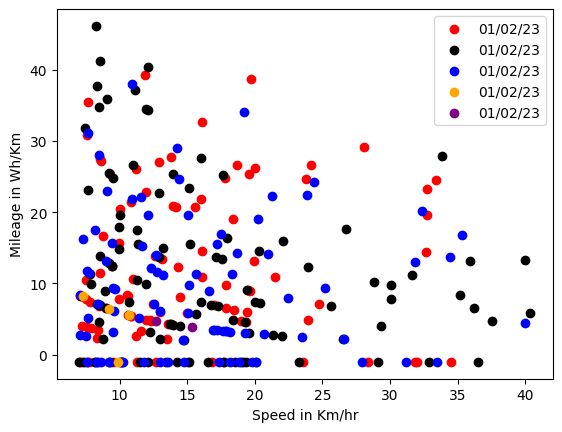

In [147]:
#pd.options.display.max_rows=100
# OneMonth.df.head(10)
#OneMonth.df.to_csv('Example.csv')

colour=['red','black','blue','orange','purple']
for i in range(0,5):
    plt.scatter(OneMonth.df.loc[(OneMonth.df['Distance']>float(0))&(OneMonth.df['date']==OneMonth.dates[i])&(OneMonth.df['Speed']>float(7)),'Speed'],OneMonth.df.loc[(OneMonth.df['Distance']>float(0))&(OneMonth.df['date']==OneMonth.dates[i])&(OneMonth.df['Speed']>float(7)),'Mileage'],color=colour[i])
plt.legend(OneMonth.df.loc[:5,'date'])
plt.ylabel('Mileage in Wh/Km')
plt.xlabel('Speed in Km/hr')

<h3>Function for find the mean squared error and printing the function</h3>

In [148]:
'''Function to calculate the mean squared error. 'true' is the actual value and 'pred' is the predicted value.'''
def mean_squared_error(true,pred):
    error=0
    for i in range(0,true.size):
        error+=(true[i]-pred[i])**2
    return error
def print_function(coff):
    for i in range(0,coff.size):
        print(coff[i],'x^',coff.size-i-1,end="+ ")

<h3>Finding the corelation between speed and mileage</h3>
<p>In this code below we are basically finding the <strong>best</strong> function of degree n for this we are checking the error value for each value of degree of the polynomial.</p>

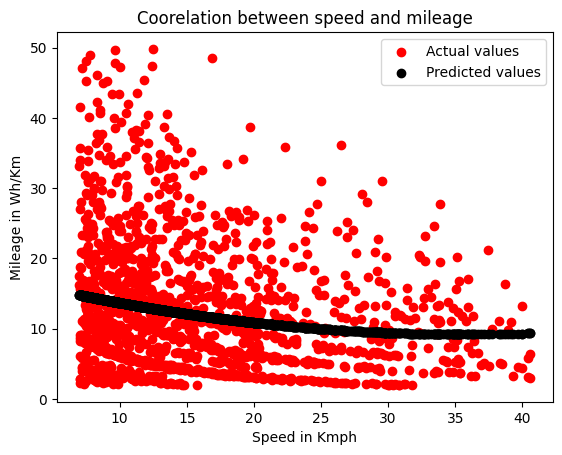

In [149]:
BestFitFunction={}# Dict(key=deg, value=[functionvalues])
minimum=0
deg=2
for i in range(2,3):
    z=np.polyfit(OneMonth.Speeds,OneMonth.MileageArray,deg=i)
    x=np.poly1d(z)
    y=np.array([])
    for j in OneMonth.Speeds:
        y=np.append(y,x(j))
    error=mean_squared_error(OneMonth.MileageArray,y)
    #print(error,end="*")
    match i:
        case 2:
            minimum=error
            BestFitFunction[deg]=[z,y]
        case default:
            if error<minimum:
                #print('Reached')
                minimum=error
                deg=i
                BestFitFunction[deg]=[z,y]
#print(deg,error)
plt.scatter(OneMonth.Speeds,OneMonth.MileageArray,color='red')
#plt.scatter(OneMonth.df['AverageSpeed_Kmph'],OneMonth.df['mileage'])
plt.scatter(OneMonth.Speeds,BestFitFunction[deg][1],color='black')
plt.xlabel("Speed in Kmph")
plt.ylabel("Mileage in Wh/Km")
plt.legend(['Actual values','Predicted values'])
plt.title('Coorelation between speed and mileage')
plt.show()
#print(BestFitFunction)

In [150]:
print_function(BestFitFunction[deg][0])

0.006797616166161014 x^ 2+ -0.48576910803320533 x^ 1+ 17.88078603226874 x^ 0+ 

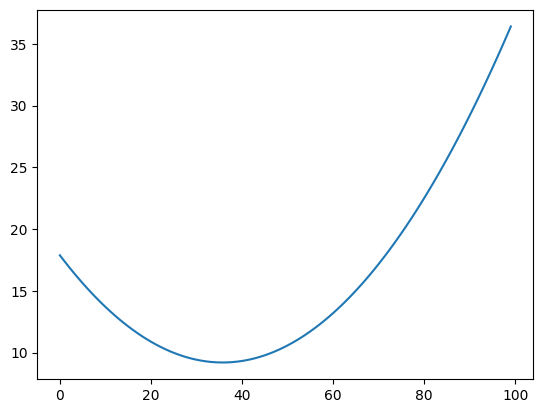

In [151]:
function=np.poly1d(BestFitFunction[deg][0])
y=np.array([])
x=np.arange(100)
for i in x:
    y=np.append(y,function(i))
plt.plot(x,y)

In [152]:
ThreeMonth=Data(pd.read_csv('3monthdata.csv',usecols=columns_to_pick))

/var/folders/t6/_mgqrzy52qsbpc1hv0gg54p40000gn/T/ipykernel_1552/2787537068.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ThreeMonth=Data(pd.read_csv('3monthdata.csv',usecols=columns_to_pick))


In [153]:
ThreeMonth.df
ThreeMonth.df.head(20)

,date,time,lat,latDirection,long,longDirection,speed,odo,batVolt,batCurrent,...,Time_seconds,latPrevious,long2-long1,Distance,Energy_Wh,EnergyConsumed,Month,TimeDifference,Speed,Mileage
0,01/12/22,0:00:05,12.948633,N,77.710304,E,0,4286,55.4,0.0,...,5,NaN,NaN,NaN,104.47886,NaN,December,5.0,NaN,-1.0
1,01/12/22,0:17:20,12.948633,N,77.710304,E,0,4286,55.4,0.0,...,1040,12.948633,0.0,0.0,104.47886,0.18859,December,1035.0,0.0,-1.0
2,01/12/22,0:19:35,12.948633,N,77.710304,E,0,4286,55.4,0.0,...,1175,12.948633,0.0,0.0,104.47886,0.18859,December,135.0,0.0,-1.0
3,01/12/22,0:25:20,12.948633,N,77.710304,E,0,4286,55.4,0.0,...,1520,12.948633,0.0,0.0,104.47886,0.18859,December,345.0,0.0,-1.0
4,01/12/22,0:46:35,12.948533,N,77.710266,E,0,4286,55.4,0.0,...,2795,12.948533,0.0,0.0,104.47886,0.18859,December,1275.0,0.0,-1.0
5,01/12/22,1:00:05,12.948533,N,77.710266,E,0,4286,55.4,0.0,...,3605,12.948533,0.0,0.0,104.47886,0.18859,December,810.0,0.0,-1.0
6,01/12/22,1:02:20,12.948520,N,77.710350,E,0,4286,55.4,0.0,...,3740,12.948520,0.0,0.0,104.47886,0.37718,December,135.0,0.0,-1.0
7,01/12/22,1:04:35,12.948520,N,77.710350,E,0,4286,55.4,0.0,...,3875,12.948520,0.0,0.0,104.47886,0.18859,December,135.0,0.0,-1.0
8,01/12/22,1:06:50,12.948520,N,77.710350,E,0,4286,55.4,0.0,...,4010,12.948520,0.0,0.0,104.47886,0.37718,December,135.0,0.0,-1.0
9,01/12/22,1:09:05,12.948520,N,77.710350,E,0,4286,55.4,0.0,...,4145,12.948520,0.0,0.0,104.47886,0.37718,December,135.0,0.0,-1.0


<h4><strong>Here we are ploting the mileage value accroding to the function obtained from the one month data</strong></h4>

/opt/homebrew/anaconda3/envs/ml/lib/python3.10/site-packages/numpy/lib/polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


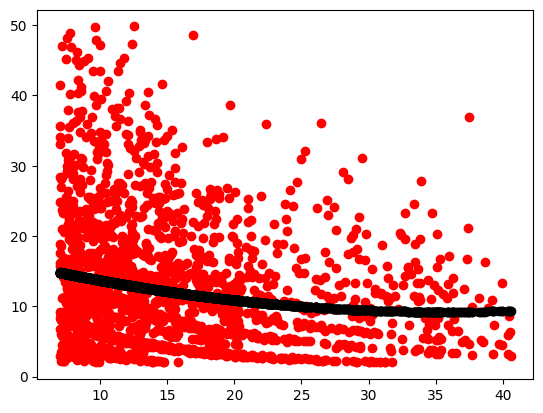

In [157]:
function=np.poly1d(BestFitFunction[deg][0])
y=np.array([])
for i in ThreeMonth.Speeds:
    y=np.append(y,function(i))
plt.scatter(ThreeMonth.Speeds,ThreeMonth.MileageArray,color='red')
plt.scatter(ThreeMonth.Speeds,y,color='black')